In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix  #to generate covariance matrices
from numpy.linalg import det
from scipy.stats import special_ortho_group
from scipy.integrate import odeint

seed = 123
np.random.seed(seed)

# Switching Linear Dynamical Systems

## 2 layers Switching linear dynamical systems

At each time $t$, our model has a *discrete latent state* $z_t$ that follows Markovian dynamics with a given Markov transition matrix $\{\pi_k\}_{k=0}^{K-1} $:

$$
z_t\in \{0,2,\dots,K-1\} \\
z_{t+1} | z_t, \{\pi_k\}_{k=0}^{K-1} \sim \pi_{z_t}
$$

where $\pi_{z_t}$ is the probability distribution for the next state, i.e. the $z_t$ th row of $\{\pi_k\}_{k=0}^{K-1}$.

The discrete state $z_t$ decides which parameters to use for the dynamics of the continuous variable. 
In this notebook we consider no other hidden varaiable apart from $z_t$.
Thus $x_t$ is the *continuous state* and the *observable* of $M$ variables that follows the conditionally linear dynamic:

$$
x_{t+1} = A_{z_{t+1}} x_t + b_{z_{t+1}} +v_t \\
v_t \overset{\text{iid}}{\sim} \mathcal{N}(0,Q_{z_{t+1}})
$$

With covariance matrix $Q_{z_{t+1}}\in \mathbb{R}^{M\times M}$, coefficients matrix $A_{z_{t+1}}\in \mathbb{R}^{M\times M}$, and vector $b_{z_{t+1}}\in \mathbb{R}^{M}$ all depending on the state $z$.

In total, we have

$$
\theta = \{ ( \pi_k,A_k,Q_k,b_k) \}_{k=1}^K
$$

parameters.

In a similar way to what happens for *Hamilton-Jacobi* equation in the *phase space* also here is necessary for the generated trajectories not to diverge that the matrix $A_{z_{t+1}}$ is orthogonal.

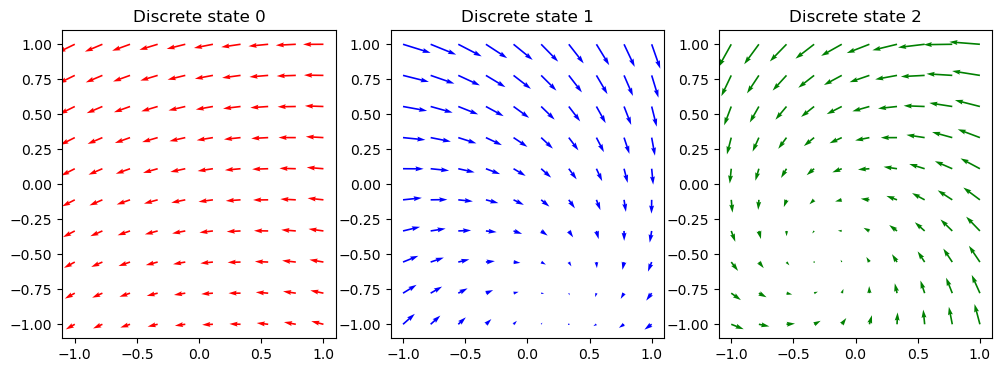

In [2]:
# number of discrete states
K=3

# number of observable variables (coordinates of a 2-D motion)
M = 2

# transition matrix, KxK
pi = np.array([
    [0.25,0.5,0.25],
    [0.1,0.1,0.8],
    [0.6,0.2,0.2]
])

# generate A,b and Q

A = np.array([special_ortho_group.rvs(M) for k in np.arange(K)])
b = np.random.randn(K,M)
Q = np.array([make_spd_matrix(M, random_state = seed + k) for k in np.arange(K)]) 

#plotting generated matrices
# plot the dynamics
fig,axs=plt.subplots(1,K,figsize=[12,4])
colors = ['red','blue','green']

# create the grid over X1 and X2
res = 10
X1 = np.linspace(-1,1,res) # is a vector of X1, dimension 10
X2 = np.linspace(-1,1,res) # is a vector of X2, dimension 10
X1,X2 = np.meshgrid(X1,X2)
X1,X2 = X1.flatten(),X2.flatten()
X = np.vstack((X1,X2))


for k in range(K):

    # now X is a vector of (M,res**2) dimension (2, 100)
    X_next = A[k] @ X + b[k].reshape(-1,1) #X_next a is the coordinates of all the 100 hundred next points
    arrows = X_next - X

    axs[k].quiver(X[0],X[1],arrows[0],arrows[1],color=colors[k])
    axs[k].set_title('Discrete state '+str(k))

# Generating trajectories

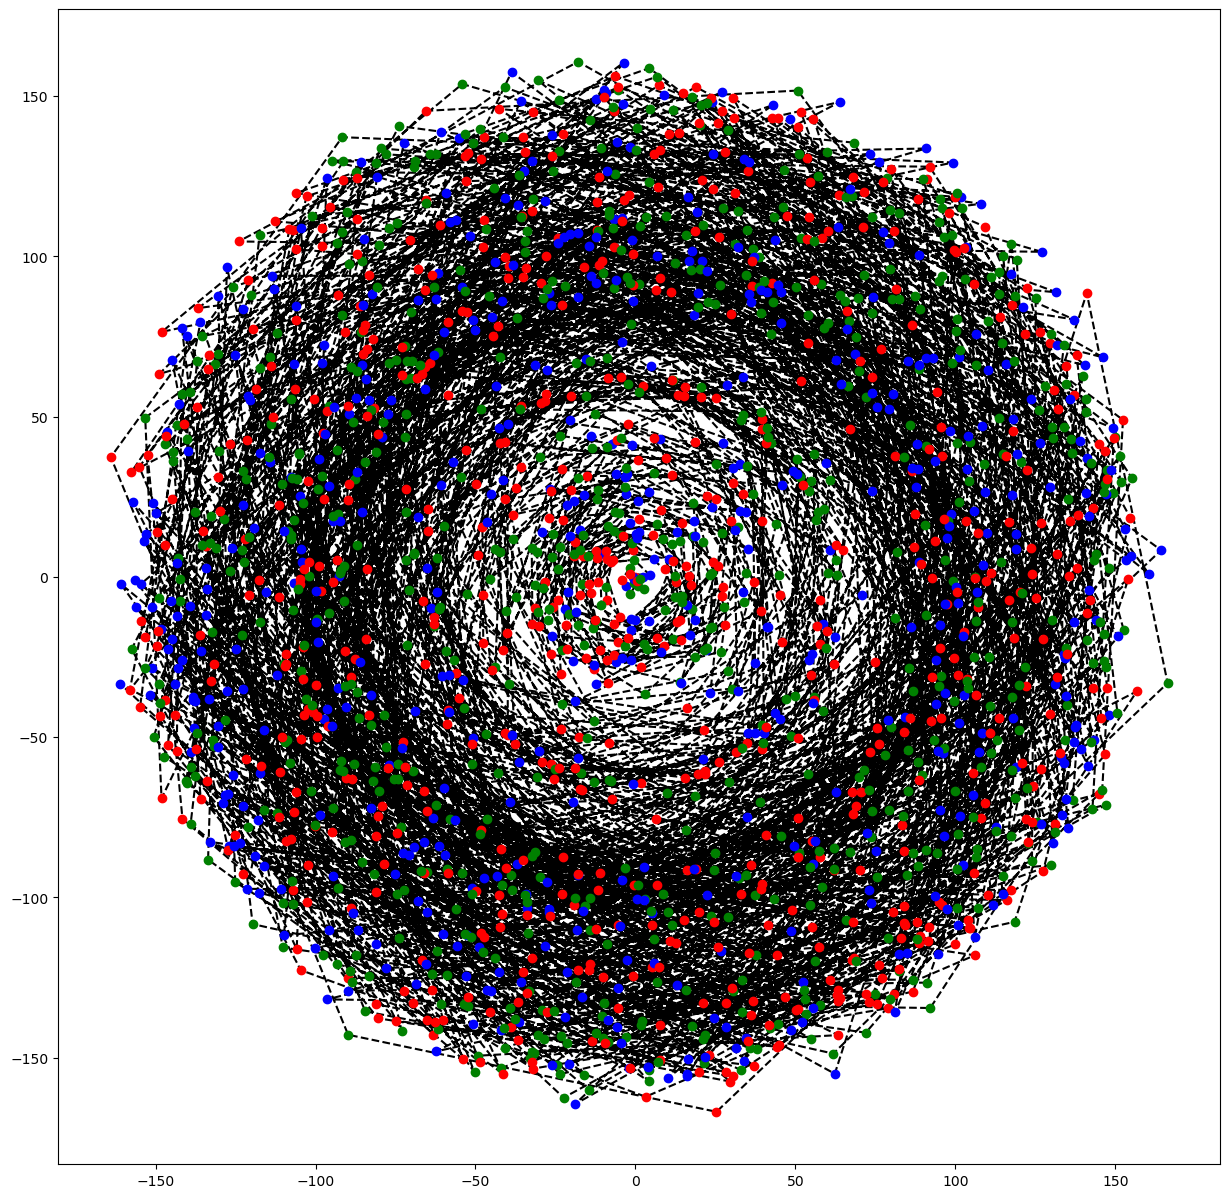

In [3]:
#number of samples you want to generate
N_samples = 2000

#initializing the k variable as 0, z ranges from 0 to K-1
z_sampled = 0

#initializing the x time-serie
x_serie = np.zeros((M,N_samples))

#want to keep track of the the z_sampled
z_serie = [z_sampled,]

for n in np.arange(0,N_samples - 1):
    
    #update variable z
    
    z_sampled = np.random.choice(K,p = pi[z_sampled])
    z_serie.append(z_sampled)
    
    #drawing noise from a normal
    noise = np.random.multivariate_normal(mean = np.zeros(M), cov = Q[z_sampled], size = 1)
   
    x_serie[:,n + 1] = A[z_sampled] @ x_serie[:,n] + noise.flatten() + b[z_sampled] 
    
fig,ax = plt.subplots(1,1,figsize = [15,15])

ax.plot(x_serie[0,:], x_serie[1,:], linestyle = '--',color = 'black')
for x_sample, y_sample,z_sample in zip(x_serie[0,:], x_serie[1,:],z_serie):
    ax.plot(x_sample, y_sample, marker = 'o',color = colors[z_sample]) 

In [4]:
np.save('./simulation/x',x_serie)
np.save('./simulation/z',z_serie)
np.save('./simulation/A',A)
np.save('./simulation/b',b)
np.save('./simulation/Q',Q)
np.save('./simulation/P',pi)

# Non Linear Dynamical system

To see how the model responds to a single but non linear dynamical system, we simulate trajectories from the Lorenz system:

$$
\begin{cases}
\dot{x} = \sigma (y-x) \\
\dot{y} = \rho x - x z - y \\
\dot{z} = x y - \beta z
\end{cases}
$$

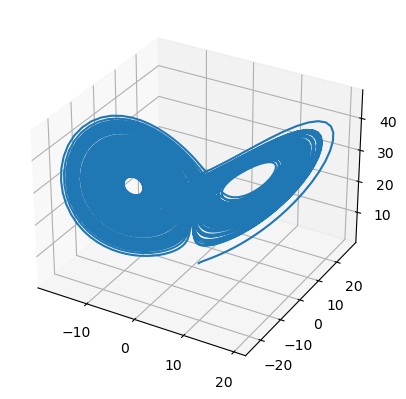

In [31]:
def lorenz(x,t,sigma=10,beta=8/3,rho=1):

    return np.array([
                        sigma*(x[1] - x[0]),
                        rho * x[0] - x[0]*x[2] - x[1],
                        x[0] * x[1] - beta * x[2]
    ])

n_samples = 10000
t = np.linspace(0,100,n_samples)

X = odeint(
    func = lorenz, 
    y0 = (1.,1.,1.),
    t = t,
    args=(10,8/3,28)
).T

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(X[0,:],X[1,:],X[2,:])

np.save('./simulation/x_lorenz.npy',X)